### Sentiment analysis on reviews data
Kei Sato

ML310B - Advanced Machine Learning

March 25, 2019

#### Project overview
For this assignment, we want to use sentiment analysis to predict the polarity of a given film review.  To build the model, we are given a corpus of 50K reviews, each associated with a score of 0 or 1, which respectively indicate that the review is negative or positive.  

#### Metrics used
We will use accuracy as the main metric used to determine if the model is successful.  But, throughout the model training and cross validation, the proportion of false positives for both classes will be monitored.


In [1]:
# Load the data...
import pandas as pd
from nltk.tokenize import word_tokenize

data = pd.read_csv('resources/Reviews.csv')
print("Number of positive and negative reviews", '\n', data["sentiment"].value_counts())
data.head()

Number of positive and negative reviews 
 1    25000
0    25000
Name: sentiment, dtype: int64


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


#### Remove HTML tags
Original sentence:
```
<br /><br />The trailer of ""Nasaan ka man"" caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon.
```

Removed HTML tags:
```
The trailer of ""Nasaan ka man"" caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon.
```

In [1]:
from bs4 import BeautifulSoup

# takes string, returns string
def strip_html(text):
    soup = BeautifulSoup(text)
    return soup.get_text()

#### Convert all text to lowercase
Original sentence:
```
The trailer of ""Nasaan ka man"" caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon.
```
Lowercase:
```
the trailer of nasaan ka man caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon.
```

In [2]:
# takes string, returns string
def lowercase(text):
    return text.lower()

#### Expand contractions
Original text:
```
The SF premise isn't unique (although it pretty much was back then)
```

Without contractions:
```
The SF premise is not unique (although it pretty much was back then)
```

In [ ]:
from nltk import tag
import json

with open('resources/contractions.json', 'r') as f:
    contractions = json.load(f)
contractions_keys = contractions.keys()

# takes tokenized text, returns tokenized text
def expand_contractions(text):
    return list(map(lambda word: contractions[word] if word in contractions_keys else word, split_sentence))


#### Remove symbols and punctuation
Original text:
```
though it makes the most sophisticated use of the ""cut-out"" method of animation (a la ""south sark""), the real talent behind
```
Removed symbols and punctuation:
```
though it makes the most sophisticated use of the cutout method of animation a la south park the real talent behind

```

In [3]:
import re

replace_re_by_space = re.compile('[/(){}\[\]\|@,;]')
delete_re_symbols = re.compile('[^0-9a-z #+_]')

def remove_symbols_punctuation(text):
    text = re.sub(delete_re_symbols.pattern, '', text)
    text = re.sub(replace_re_by_space.pattern, ' ', text)
    return text

#### Remove stop words
Original text:
```
I went to this movie tonight with a few friends not knowing more than the Actors that were in it, and that it was supposed to be a horror movie.
```
Removed stop words:
```
I went movie tonight friends knowing Actors , supposed horror movie

```

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    filtered_sentence = [w for w in token_word if not w in stop_words]
    return filtered_sentence


#### Text Lemmatization
Original text:
```
I went to this movie tonight with a few friends not knowing more than the Actors that were in it, and that it was supposed to be a horror movie.
```
Lemmatization applied:
```
I went movie tonight friends knowing Actors , supposed horror movie

```

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def text_lemmatization(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = list(map(lambda word: wordnet_lemmatizer.lemmatize(word), text))
    return text

text = "women cats pony"

# print(text.split())
text = word_tokenize(text)
print(text_lemmatization(text))

['women', 'cats', 'pony']
['woman', 'cat', 'pony']


#### Initial Text Processing
The reviews corpus has 50,000 reviews and is evenly split between positive and negative reviews, so that it contains 25,000 positive and 25,000 negative reviews.  Before doing any more data exploration, we process the text using standard techniques.  Much of this code was taken from the Lesson 8 HW assignment.

The first step is apply some basic text processing, it was done in the following order.
1.  Remove proper nouns:  This was done by using the NLTK position tagging functionality to identify proper nouns.
2.  Expand contractions
3.  Convert all text to lowercase
4.  Remove `<br />` characters, this was because the `<br />` HTML tag was present in many reviews.  This part of cleaning the text was specific to this corpus.
5.  Remove symbols and punctuation
6.  Remove stop words.  For this application, I also removed the words "movie" and "film" because they were occured very often throughout positive and negative reviews.

After cleaning the text, lemmatization is applied.  I did try to apply stemming to the dataset, but that produced too many non words and so it has been omitted from the text processing steps.

In [2]:
# Taken Lesson 8 HW assignment
from nltk.corpus import stopwords
from nltk import tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import json
import nltk

# these are only to be run once
# nltk.download("stopwords")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('wordnet')

# setting global variables
with open('resources/contractions.json', 'r') as f:
    contractions = json.load(f)
contractions_keys = contractions.keys()

replace_re_by_space = re.compile('[/(){}\[\]\|@,;]')
delete_re_symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))
stop_words.add("movie")
stop_words.add("film")

def combine_tokened_words(tokened_words):
    length_of_string=len(tokened_words)
    text_new=""
    for w in tokened_words:
        if w!=tokened_words[length_of_string-1]:
             text_new=text_new+w+" " # when w is not the last word so separate by whitespace
        else:
            text_new=text_new+w
    return text_new

# converts to lowercase and removes <br />, punctuation, stop words, and numbers
def text_processing(text):
    # remove HTML
    text = strip_html(text)
    # lower case letters
    text = lowercase(text)
    # remove punctuation/symbols
    text = remove_symbols_punctuation(text)

    # use tokenized text
    text = word_tokenize(text)
    
    # expand contractions
    text = expand_contractions(text)
    # remove stop words
    text = remove_stop_words(text)
    # text lemmatization
    text = text_lemmatization(text)
    
    return text
    
#     tagged_sentence = tag.pos_tag(text.split())
#     text = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
#     test = list(map(lambda word: contractions[word] if word in contractions_keys else word, text))
#     text = (' '.join(text))
    
#     text = text.lower()
#     text = text.replace("<br />", '')
#     text = re.sub(replace_re_by_space.pattern, ' ', text)
#     text = re.sub(delete_re_symbols.pattern, '', text)
#     token_word = word_tokenize(text)

#     # filtered_sentence contain all words that are not in stopwords dictionary    
#     filtered_sentence = [w for w in token_word if not w in stop_words]
#     return filtered_sentence

# Lemmatizes words
# def text_lemmatization(text):
#     wordnet_lemmatizer = WordNetLemmatizer()
#     text = list(map(lambda word: wordnet_lemmatizer.lemmatize(word), text))
#     return text

test_data = data.head(10)
# test_data["review"] = test_data["review"].apply(lambda text:
#                                                 combine_tokened_words(
#                                                     text_lemmatization(
#                                                         text_processing(text)
#                                                     )
#                                                   )
#                                                )

print()
print("done processing data")

done processing data


#### Data exploration
Below is some initial data exploration.  We can see that the average length of positive and negative reviews is roughtly the same.  The ten most frequently occuring words are also very similar across between the sets of positive and negative reviews.  I also outputted the ten least commonly occuring words, in part for my own curiosity and to verify that the ten least commonly occuring words were still complete words.

In [3]:
import numpy as np
from collections import Counter 
from functools import reduce
from operator import itemgetter
import heapq

# Get average length of reviews
def get_avg_length_review(data, sentiment):
    relevant_reviews = data.loc[data["sentiment"] == sentiment]["review"]
    avg_review_length = list(map(lambda review: len(review.split()), relevant_reviews))
    return int(np.mean(avg_review_length))
print("Average word count of negative reviews:", get_avg_length_review(test_data, 0))
print("Average word count of positive reviews:", get_avg_length_review(test_data, 1))

# Get 10 most and least frequently occuring words, verify that real words are coming through
def get_most_least_common_words(data, sentiment):
    relevant_reviews = data.loc[data["sentiment"] == sentiment]["review"]
    all_relevant_reviews = reduce(lambda accum, curr: accum + curr, relevant_reviews)
    counted_words = Counter(all_relevant_reviews.split())
    most_common = counted_words.most_common(10)
    least_common = heapq.nsmallest(10, counted_words.items(), key=itemgetter(1))
    return most_common, least_common

negative_reviews = get_most_least_common_words(test_data, 0)
positive_reviews = get_most_least_common_words(test_data, 1)

print('\n')
print("10 most common words in negative reviews:", negative_reviews[0])
print("10 least common words in negative reviews:", negative_reviews[1])
print('\n')
print("10 most common words in positive reviews:", positive_reviews[0])
print("10 least common words in positive reviews:", positive_reviews[1])


Average word count of negative reviews: 100
Average word count of positive reviews: 99


10 most common words in negative reviews: [('one', 23823), ('like', 21496), ('even', 14625), ('character', 13744), ('good', 13448), ('would', 13361), ('time', 13139), ('get', 12928), ('bad', 12683), ('make', 12312)]
10 least common words in negative reviews: [('callinternet', 1), ('garbageanyone', 1), ('60ship', 1), ('twitter', 1), ('fauxinfant', 1), ('seachange', 1), ('lessoften', 1), ('yearsmany', 1), ('imaginationchallenged', 1), ('flopperoo', 1)]


10 most common words in positive reviews: [('one', 25089), ('like', 16898), ('time', 14278), ('character', 13460), ('good', 13447), ('story', 12856), ('see', 11564), ('great', 11314), ('make', 10805), ('get', 10792)]
10 least common words in positive reviews: [('ralphtheallpurposeanimal', 1), ('filmedhumanity', 1), ('nextarguebly', 1), ('breakem', 1), ('1010big', 1), ('samaddhi', 1), ('fourmillion', 1), ('ucomfort', 1), ('upoint', 1), ('ufast', 1)]


#### Methodology
The data transformed by using TFIDIF then fed into a Logistic Regression classifier.  I am using a test train split of 30% and 70%.  The model is run with data that is processed with different ngram lengths and minimum document frequency values.  I am also using the SKlearn cross validation module to test different parameters for the Logistic Regression model itself.

I chose the Logistic Regression model because this is a supervised learning problem with binary labels.  I also tried running an SVM model but it took too long to run on my machine with the complete dataset.  Using a decision tree was also considered but the dataset seemed too sparse to use that model.

For this example, the minimium document frequency is varied while the maximum document frequency remains constant at 0.9.  The model is tested against the following min_df values: 0.0001, 0.00025, 0.0005, 0.001, 0.0025.  I chose to vary the minimum value instead of the maximum value because I assumed that would reduce the instances of non words in the dataset as well as reducing noise.  However, I am interested in the effect that changing the max_df would have as well.  The n-grams value is also varied, using values between 1 and 4.  I did not go beyond (1, 3) because using a smaller portion of data, I was not seeing a significant difference in results after categorizing words using n-grams greater than 3.  After processing this data, if the transformed TFIDIF matrix had more features than instances, I would not run the model.  This was done because when running the model on such a matrix (with a subset of data) there was performance degredation, which was likely due to the Logistic Regression classifier not handling datasets with more features than rows well.  
- Reducing the feature spacing using the sklearn Truncated SVD module was also considered.  However, in the documentation, the suggested value for n_components is 100, and when I ran the model with that parameter set as 200, the accuracy remained flat.  I believe this is because the same 200 n-grams were being selected for each run.  Some variation of PCA is appropriate for this exercise, but because, I assume, the n_components parameter would need to be well over the recommended value of 100 to affect this dataset, that step has been forgone.


In [4]:
from sklearn import metrics
    
def get_incorrect_predictions(data, y_true, y_pred):
    predicted_pos = 0
    predicted_neg = 0
    correct_predictions = 0
    incorrect_predictions = pd.DataFrame({'review': [], 'sentiment': []})
    for i in range(0, len(y_true)):
        if y_true[i] == y_pred[i]:
            correct_predictions+=1
        else:
            incorrect_predictions.loc[len(incorrect_predictions)] = [data[i], y_pred[i]]
            if y_pred[i] == 1:
                predicted_pos+=1
            else:
                predicted_neg+=1
    print("Predicted POSITIVE, actually NEGATIVE", round(float(predicted_pos)/float(len(y_true)), 3))
    print("Predicted NEGATIVE, actually POSITIVE", round(float(predicted_neg)/float(len(y_true)), 3))
    print('\n')
    return incorrect_predictions

In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

# returns the accuracy
def print_metrics(x_test, y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 3)
#     print("Accuracy:", acc)        
#     print("AUC Score:", round(roc_auc_score(y_test, y_pred), 3))

#     incorrect_pred = get_incorrect_predictions(list(x_test), list(y_test), y_pred)
#     print("For incorrectly predicted reviews:")
#     print("Most and least common of predicted negative reviews:", get_most_least_common_words(incorrect_pred, 0))
#     print("Most and least common of predicted positive reviews:", get_most_least_common_words(incorrect_pred, 1))
    return acc

def run_model_cv(data):   
    x_train, x_test, y_train, y_test = train_test_split(
        data["review"],
        data["sentiment"],
        test_size=0.3,
        random_state=42
    )

    
    ngram_range = [
        (1, 1),
        (1, 2),
        (2, 2),
        (2, 3),
        (2, 4),
        (3, 4),
        (3, 3)
    ]
    
    min_df_range = [
        0.0001,
        0.00025,
        0.0005,
        0.001,
        0.0025
    ]
    
    accuracy_by_ngram = []
    for ngram_param in ngram_range:
        accuracy_by_min_df = []
        for min_df_param in min_df_range:
#             print("ngram range and min_df value", ngram_param, min_df_param)
            vectorizer = TfidfVectorizer(max_df=0.9, min_df=min_df_param, ngram_range=ngram_param).fit(x_train)
            _x_train = vectorizer.transform(x_train)

            # If there are more columns than rows, exit           
            if (_x_train.shape[1] < _x_train.shape[0]):
                _x_test = vectorizer.transform(x_test)
#                 print("done vectorizing")

                cv_clf = GridSearchCV(
                            LogisticRegression(),
                            [
                                {
                                    "solver": ["sag", "saga"],
                                    "C": [0.9, 0.95, 0.99],
                                    "max_iter": [150, 200, 250]
                                }
                            ],
                            cv=5,
                            refit=True
                        )
#                 print("fitting the model on dataset with these dimensions", _x_train.shape)
                cv_clf.fit(_x_train, y_train)
#                 print("Best params:", cv_clf.best_params_)

                y_pred = cv_clf.predict(_x_test)
                accuracy = print_metrics(x_test, y_test, y_pred)
                accuracy_by_min_df.append(accuracy)
            else:
                accuracy_by_min_df.append(0)
#                 print("Too many features, exiting", _x_train.shape)
        accuracy_by_ngram.append({
          "scores": accuracy_by_min_df,
          "label": ngram_param
        })
    return accuracy_by_ngram, min_df_range

model_results = run_model_cv(test_data)
print("done fitting the model")


done fitting the model


|n-gram|min document freq|accuracy|
|------|------|-----|
|(1, 1)| 0.0001|0.884|
|(1, 1)| 0.00025|0.884|
|(1, 1)| 0.0005|0.885|
|(1, 1)| 0.001|0.883|
|(1, 1)| 0.0025|0.88|
|(1, 2)| 0.0001|n/a|
|(1, 2)| 0.00025|n/a|
|(1, 2)| 0.0005|0.889|
|(1, 2)| 0.001|0.887|
|(1, 2)| 0.0025|0.883|
|(2, 2)| 0.0001|n/a|
|(2, 2)| 0.00025|n/a|
|(2, 2)| 0.0005|0.816|
|(2, 2)| 0.001|0.793|
|(2, 2)| 0.0025|0.743|
|(2, 3)| 0.0001|n/a|
|(2, 3)| 0.00025|n/a|
|(2, 3)| 0.0005|0.816|
|(2, 3)| 0.001|0.792|
|(2, 3)| 0.0025|0.743|
|(2, 4)| 0.0001|n/a|
|(2, 4)| 0.00025|n/a|
|(2, 4)| 0.0005|0.816|
|(2, 4)| 0.001|0.792|
|(2, 4)| 0.0025|0.743|
|(3, 3)| 0.0001|0.675|
|(3, 3)| 0.00025|0.633|
|(3, 3)| 0.0005|0.585|
|(3, 3)| 0.001|0.554|
|(3, 3)| 0.0025|0.552|
|(3, 4)| 0.0001|0.675|
|(3, 4)| 0.00025|0.633|
|(3, 4)| 0.0005|0.585|
|(3, 4)| 0.001|0.554|
|(3, 4)| 0.0025|0.522|

#### Visualization
The resulting graph displays the minimum document frequency against the accuracy, coded by the n-gram value. 
The accuracy seems unaffected by the n-gram length and goes down when increasing minimum document frequency.  In general, most parameters yield an accuracy between 85% and 89%, there is not a significant difference between the proportion of misclassified positive or negative documents.

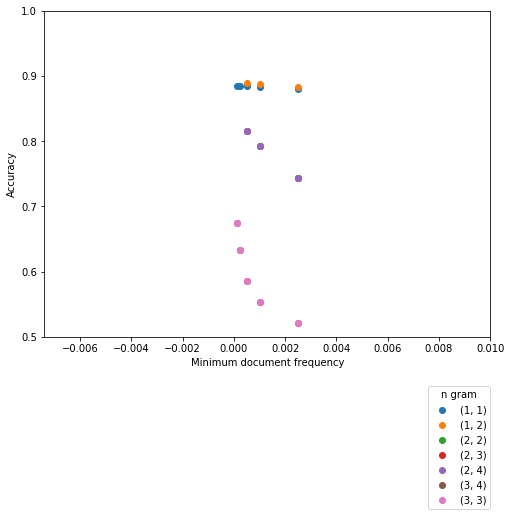

In [7]:
import matplotlib.pyplot as plt

def graph_accuracy(accuracies, min_dfs):
    plt.figure(figsize=(8, 6))
    plt.gca().set_ylim(bottom=0.5)
    for accuracy in accuracies:
        plt.scatter(min_dfs, list(accuracy["scores"]), label=accuracy["label"])
        plt.xlabel('Minimum document frequency')
        plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc="best", borderaxespad=0, title="n gram")
    return plt.show()

graph_accuracy(model_results[0], model_results[1])

#### Analysis
The accuracies were much better for lower n-gram values.  The best results came from using an n-gram range of 1-2 with an accuracy of 88.9% using a minimum document fequency of 0.0005, which was the lowest value tested that did not produce a matrix with more columns than rows.  Performance drops percipitously when the n-gram range is increased to 2-4 or 3, yielding results that are not much better than guessing (considering the class distribution of the given dataset).  The cross validation module often favored a higher value of C for the Logistic Regression model, usually equal to 0.99 or 0.95.  CV only selected a C of 0.9 when the min document frequency was higher, indicating that the cross validation was accounting for overfitting as more data was included.

The model also consistently misclassified positive and negative reviews at roughly the same rate.

#### Conclusion
These results indicate that when using Logistic Regression and a dataset of this size, a lower n-gram is preferred and including as many features before degrading model performance is optimal.  This may indicate that the language of the reviews does not have much consistency on a 2-3 word basis or that phrases are used at the same rate within positive and negative reviews.

The main challenge with this dataset is its high dimensionality.  While there are 50,000 data points, there are many more features, in this case n-grams, within this corpus.  Cleaning the data can involve many word transformations, as well detecting if a word is mispelled.  Even after the data is cleaned, we have to determine how much the data to use with the model to reduce the large amount of noise.

#### Further analysis
While this model was able to achieve a roughly 90% accuracy across both classes, there are many more ways to improve on this, either by doing more feature engineering or using a more robust model.

Different models:  It would be worthwhile to try different models on the dataset.  An SVM would be appropriate because this is a binary classification problem.  However, I am also interested in the effects of measuring document similarity and using that for a clustering model.

Word attributes:  There are other qualities of the individual words that could be further processed.  For example, whether or not the average word length of a review is correlated to the sentiment of the review.  Other aspects could include the obscurity and if the words are mispelled.

N-grams and phrases:  This implmentation is processing the data into different n-grams, but there could be more analysis done with n-grams.  Such as collecting longer n-grams (3 to 4 words) by sentiment of the review they appear in and weighting those phrases more while training data.

Stemming:  I chose not to include stemming because the nltk libraries were producing too many non words, but it would definitely be worthwhile to invest more time into applying stemming correctly.

Sentence structure:  The sentence structure used could be indicative of the document's sentiment.  One hypothesis is that negative reviews have more sentences written in the first person, such beginning with "I think ..."  We can also explore if positive or negative reviews are correlated with incorrectly or correctly structured sentences.  

#### References:
NLTK book http://www.nltk.org/book/

Blog post on sentiment analysis https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41